# Decision Trees on Amazon Fine Food Reviews

In [0]:
#importing necessary packages
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import pickle
import sklearn.cross_validation
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [0]:
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,roc_auc_score,roc_curve

## Reading already Cleaned, Preprocessed data from database

After removing stopwords, punctuations, meaningless characters, HTML tags from Text 
and done stemming. Using it directly as it was alredy done in prevoius assignment

In [0]:
#Reading
conn= sqlite3.connect('cleanedTextData.sqlite')
data= pd.read_sql_query('''
SELECT * FROM Reviews
''',conn)
data=data.drop('index',axis=1)
data.shape

(364171, 11)

In [0]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

In [0]:
data['CleanedText'].head(3)

0    witti littl book make son laugh loud recit car...
1    rememb see show air televis year ago child sis...
2    beetlejuic well written movi everyth act speci...
Name: CleanedText, dtype: object

 ## Sorting on the basis of 'Time' and taking top 100k pts

 This data has time attribute so it will be reasonable to do time based splitting instead
   of random splitting.

 So, before splitting we have to sort our data according to time and here we are taking
 100k points from our dataset(population)

In [0]:
data["Time"] = pd.to_datetime(data["Time"], unit = "ms")
data = data.sort_values(by = "Time")

In [0]:
#latest 100k points according to time
data= data[:100000]
len(data)

100000

## Splitting data into train70% test30%

Splitting our data into train and test data.
* train data will train our ML model
* cross validataion data will be for determining our hyperparameter
* test data will tell how Generalized our model is
* dataframes after splitting:- traindata, testdata

In [0]:
traindata, testdata= train_test_split(data, test_size= 0.3, shuffle= False,stratify= None)
print(len(traindata),len(testdata))

70000 30000


In [0]:
Xtrain,Xtest= traindata['CleanedText'],testdata['CleanedText']
Ytrain,Ytest= traindata['Score'],testdata['Score']

In [0]:
# converting positive to 1 and negative to 0
Ytrain=Ytrain.map(lambda x:1 if x=='Positive' else 0)
Ytest=Ytest.map(lambda x:1 if x=='Positive' else 0)

Taking Text and score(class) as sequences
* traindata -> Xtrain, Ytrain
* testdata -> Xtest, Ytest

# SelfDefined Functions

Three functions are defined below:-
* GridCvDt()- Gridsearch crossvalidation (on Depth and min_split) on given data using decision trees model
* DecisionTree()- Apply DecisiontreeClasifier on train data and get performance metrics of model
* show_most_informative_features()- Important Features

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np

def GridCvDt(xtrain):
    '''
    Gridsearch crossvalidation (on Depth and min_split) on given data using decision trees model
    Then it plots the score vs parameter graph
    Uses roc_auc as scoring metric
    '''
    dtCLF= DecisionTreeClassifier(criterion='gini',class_weight='balanced')
    parameters= {'max_depth': [1,3,5,8,20,50,100], 'min_samples_split': [5,10,100,500,1000,1500]}
    GSC= GridSearchCV(dtCLF, parameters, scoring= 'roc_auc', n_jobs= -1,cv=5)
    GSC.fit(xtrain,Ytrain)
    
    #plotting
    min_split = GSC.best_params_['min_samples_split']
    max_depth = GSC.best_params_['max_depth']

    #best outcome
    print('\n',GSC.best_estimator_)
    print('Best Hyperparameter is ',GSC.best_params_)
    print('Best auc score is ',GSC.best_score_)
    
    #return
    return (max_depth,min_split,GSC)

def GridCvresult(GSC):
    keys=['param_max_depth','param_min_samples_split','mean_train_score','mean_test_score']
    dic = {x:GSC.cv_results_[x] for x in keys}
    res= pd.DataFrame(dic)
    res1= res.sort_values('mean_train_score')
    x=list(res1['param_max_depth'])
    y=list(res1['param_min_samples_split'])
    z1=list(res1['mean_train_score'])
    z2=list(res1['mean_test_score'])


    #2D plot
    plt.figure(1)
    plt.plot(x,z1)
    plt.plot(x,z2)
    plt.legend(('Train','Cv'))
    plt.xlabel('Hyperparameter depth')
    plt.ylabel('auc score')
    plt.title('Auc score vs Depth')
    plt.figure(2)
    plt.plot(y,z1)
    plt.plot(y,z2)
    plt.legend(('Train','Cv'))
    plt.xlabel('Hyperparameter split')
    plt.ylabel('auc score')
    plt.title('Auc score vs split')
    plt.show()
    

In [0]:
def DecisionTree(depth,split,xtrn,xtst):    
    '''
    Apply DecisiontreeClasifier on train data and get performance of model using different metrics
    '''
    #Testing performance on Test data
    clf= DecisionTreeClassifier(criterion='gini',max_depth= depth, min_samples_split= split, class_weight='balanced')
    clf.fit(xtrn,Ytrain)
    y_train_pred= clf.predict(xtrn)
    y_pred = clf.predict(xtst)
    #Printing Different scores
    print("AUC score on test set: %0.3f%%"%(roc_auc_score(Ytest, y_pred)*100))
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(Ytest, y_pred)*100))
    print("Precision on test set: %0.3f"%(precision_score(Ytest, y_pred)*100))
    print("Recall on test set: %0.3f"%(recall_score(Ytest, y_pred)*100))
    print("F1-Score on test set: %0.3f"%(f1_score(Ytest, y_pred)*100))
    #Confusion matrics
    fpr_train,tpr_train,ts_train=roc_curve(Ytrain,y_train_pred)
    fpr,tpr,ts=roc_curve(Ytest,y_pred)
    plt.plot(fpr,tpr,label='TEST')
    plt.plot(fpr_train,tpr_train,label='TRAIN')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
    print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
    df_cm = pd.DataFrame(confusion_matrix(Ytest, y_pred), range(2),range(2))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [0]:
def show_most_informative_features(vectorizer, clf, n=15):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    print("Top 20 Features of learned model\n")
    for (coef_1, fn_1) in top:
        print("\t%.4f\t%-15s" % (coef_1, fn_1))
        
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-
#for-scikit-learn-classifiers

---
# BOW Vectorization-------------------------------------------------
Bow vectorization is basic technique to convert a text into numerical vector.
* We will build a model on train text using fit-transform
* Then transform (test) text on model build by train text
* Transformed data will be in the form of sparse matrix

In [0]:
# vectorizing X and transforming
bowModel=CountVectorizer()
XtrainBOWV=bowModel.fit_transform(Xtrain.values)

In [0]:
XtestBOWV= bowModel.transform(Xtest)
XtestBOWV.shape

(30000, 39730)

### Using GridSearch for crossvalidation, we use here a function GridCvDt() which will return best parameters required

In [0]:
depth,split,GSC1= GridCvDt(XtrainBOWV)


 DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=1500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Best Hyperparameter is  {'max_depth': 50, 'min_samples_split': 1500}
Best auc score is  0.8059046084022341


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True



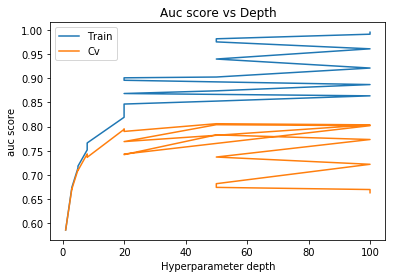

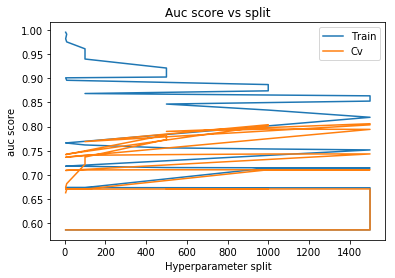

In [0]:
GridCvresult(GSC1)

#### 3D plot of Depth and split
![alt text](BOW.png "BOW")

So, balancing overfit and underfit
* Best max_depth 50 min_samples_split 1500
* Best auc score is  80.59%

### Training model using best hyperparameters got from GridsearchCrossvalidation and further checking its performance

AUC score on test set: 74.399%
Accuracy on test set: 74.113%
Precision on test set: 94.887
Recall on test set: 74.006
F1-Score on test set: 83.155


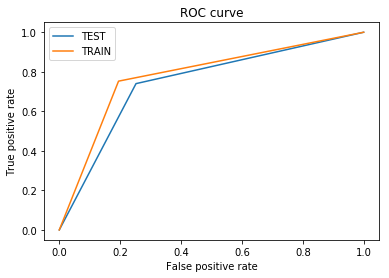

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



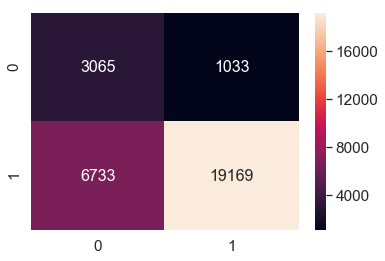

In [0]:
DecisionTree(depth,split,XtrainBOWV,XtestBOWV)

### Printing 20 Important Features

In [0]:
BOWdt= DecisionTreeClassifier(criterion='gini',max_depth= depth, min_samples_split= split, class_weight='balanced')
BOWdt.fit(XtrainBOWV,Ytrain)
show_most_informative_features(bowModel, BOWdt, n=20)

Top 20 Features of learned model

	0.1304	great          
	0.0783	best           
	0.0667	love           
	0.0597	disappoint     
	0.0407	delici         
	0.0326	perfect        
	0.0280	good           
	0.0278	excel          
	0.0277	favorit        
	0.0177	nice           
	0.0164	tast           
	0.0135	find           
	0.0132	easi           
	0.0121	product        
	0.0119	money          
	0.0108	bad            
	0.0097	wonder         
	0.0093	would          
	0.0092	tasti          
	0.0091	unfortun       


### Visualizing Learned Decision tree using graphviz

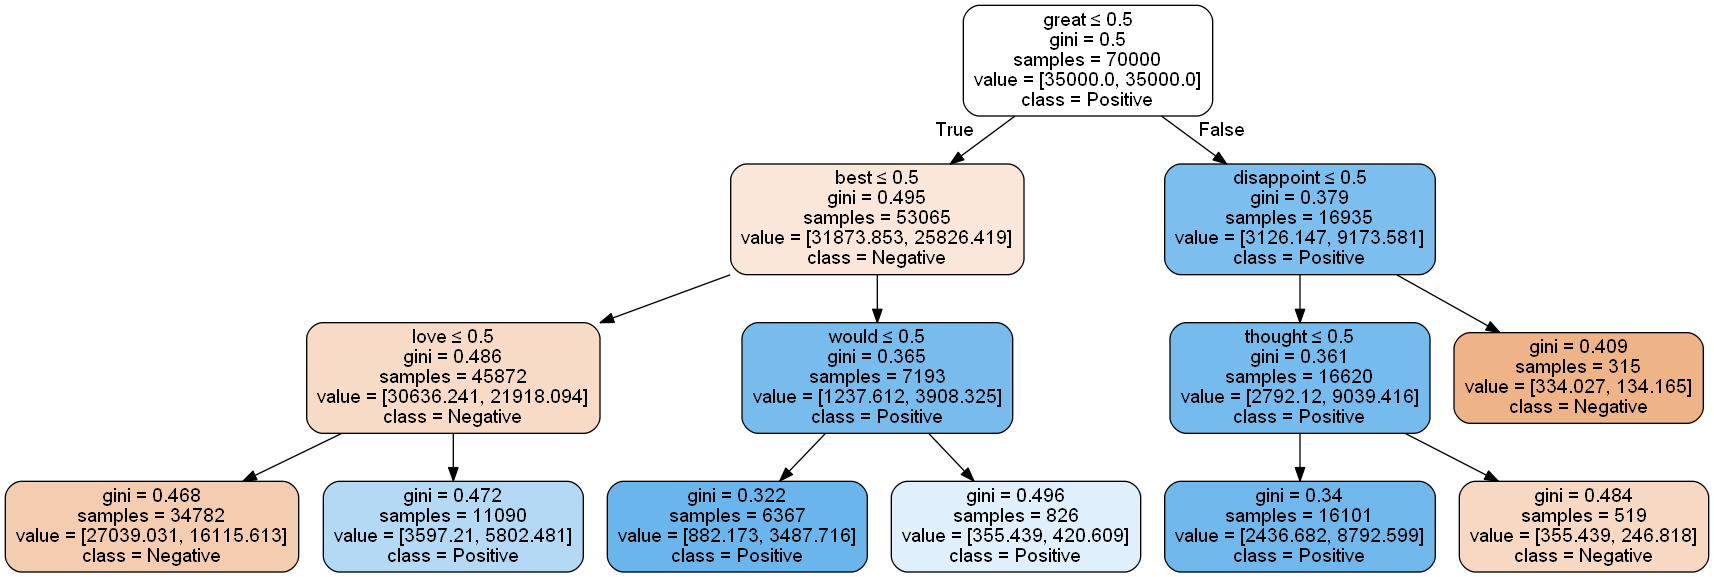

In [0]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
BOWdt= DecisionTreeClassifier(criterion='gini',max_depth= 3, min_samples_split= 1500, class_weight='balanced')
BOWdt.fit(XtrainBOWV,Ytrain)

dot_data = StringIO()

export_graphviz(BOWdt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,class_names= ['Negative','Positive'],feature_names=bowModel.get_feature_names() )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

***
# TFIDF vectorization-------------------------------------------------

* We will build a model on train text using fit-transform
* Then transform (test) text on model build by train text
* Transformed data will be in the form of sparse matrix

In [0]:
# generating vetor out of text using tfidf
tfidfModel=TfidfVectorizer()
XtrainTFIDFV= tfidfModel.fit_transform(Xtrain)
XtestTFIDFV= tfidfModel.transform(Xtest)

### Using GridSearch for crossvalidation, we use here a function GridCvDt() which will return best parameters required

In [0]:
depth,split,GSC2= GridCvDt(XtrainTFIDFV)


 DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=1500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Best Hyperparameter is  {'max_depth': 50, 'min_samples_split': 1500}
Best auc score is  0.7994019862396834


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True



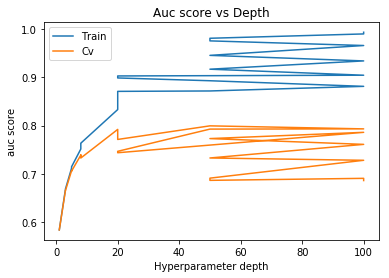

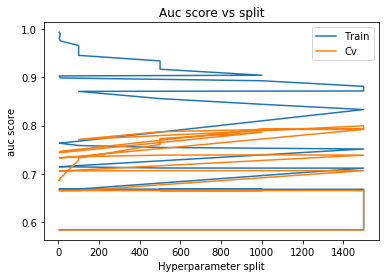

In [0]:
GridCvresult(GSC2)

#### 3D plot of Depth and split
![alt text](TFIDF.png "TFIDF")

So, balancing overfit and underfit
* Best max_depth 50 min_samples_split 1500
* Best auc score is  79.94%

### Training model using best hyperparameters got from GridsearchCrossvalidation and further checking its performance

AUC score on test set: 73.369%
Accuracy on test set: 75.900%
Precision on test set: 94.163
Recall on test set: 76.851
F1-Score on test set: 84.631


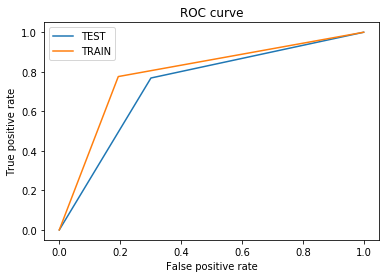

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



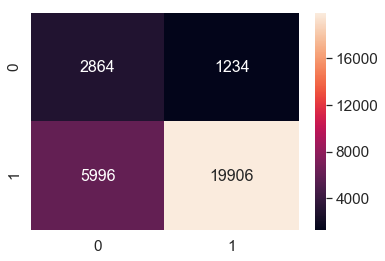

In [0]:
DecisionTree(depth,split,XtrainTFIDFV,XtestTFIDFV)

### Printing 20 Important Features

In [0]:
TFdt= DecisionTreeClassifier(criterion='gini',max_depth= depth, min_samples_split= split, class_weight='balanced')
TFdt.fit(XtrainTFIDFV,Ytrain)
show_most_informative_features(tfidfModel, TFdt, n=20)

Top 20 Features of learned model

	0.1307	great          
	0.0785	best           
	0.0668	love           
	0.0599	disappoint     
	0.0408	delici         
	0.0326	perfect        
	0.0280	good           
	0.0279	excel          
	0.0277	favorit        
	0.0178	nice           
	0.0165	tast           
	0.0135	find           
	0.0132	easi           
	0.0125	money          
	0.0121	product        
	0.0108	bad            
	0.0098	wonder         
	0.0093	would          
	0.0092	tasti          
	0.0090	terribl        


### Visualizing Learned Decision tree using graphviz

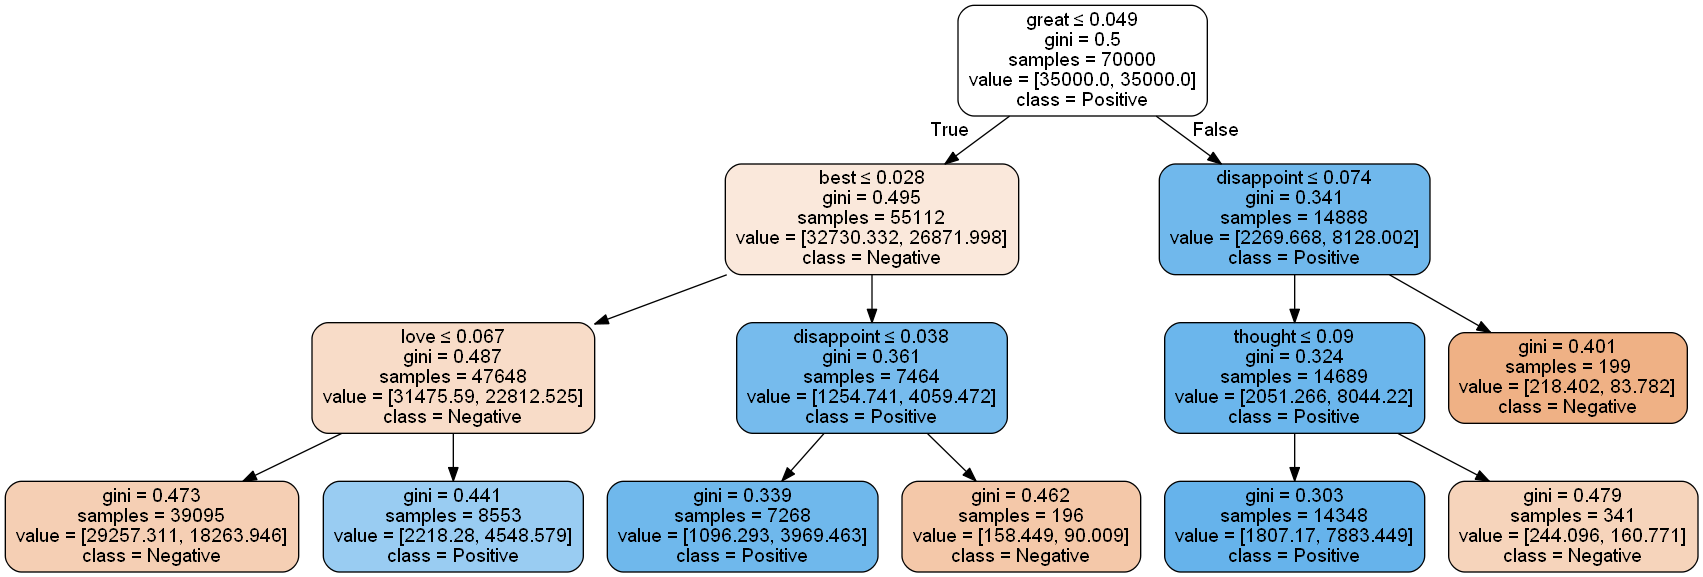

In [0]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
TFIDFdt= DecisionTreeClassifier(criterion='gini',max_depth= 3, min_samples_split= 1500, class_weight='balanced')
TFIDFdt.fit(XtrainTFIDFV,Ytrain)

dot_data = StringIO()

export_graphviz(TFIDFdt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,class_names= ['Negative','Positive'],feature_names=bowModel.get_feature_names() )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# Avg W2V vectorization-------------------------------------------------

In [0]:
import gensim
# training our gensim model on our train text
import re
import string
def cleanhtml(sentance): #substitute expression contained in <> with ' '
    cleaned= re.sub(re.compile('<.*?>'),' ',sentance)
    return cleaned
#function for removing punctuations chars
def cleanpunc(sentance):
    cleaned= re.sub(r'[?|!|\'|"|#]',r'',sentance)
    cleaned= re.sub(r'[.|,|)|(|\|/]',r'',sentance)
    return cleaned
i=0
lists=[]

for sent in Xtrain.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    lists.append(filtered_sentence)


w2v_model= gensim.models.Word2Vec(lists,min_count=5,size=50,workers=4)
print(len(list(w2v_model.wv.vocab)))

C:\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


10351


In [0]:
w2v_words = list(w2v_model.wv.vocab)

In [0]:
# converting list of sentance into list of list of words
# then to vector using avg w2v
# function to convert list of list of words to vect using avg w2v
def w2vVect(X):
    '''
    This function takes list of sentance as input (X) and convert it into 
    list of list of words and then feed it into our gensim model to get vector
    and then take its average, finally returns sent_vectors(vector of sentance)
    *************GENSIM MODEL WAS TRAINED ON TRAINDATA***************
    '''

    lists=[]
    for sent in X.values:
        filtered_sentence=[]
        sent=cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if(cleaned_words.isalpha()):
                    filtered_sentence.append(cleaned_words.lower())
                else:
                    continue
        lists.append(filtered_sentence)

    sent_vectors = []; 
    for sent in lists: 
        sent_vec = np.zeros(50) 
        cnt_words =0;
        for word in sent: 
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [0]:
# Vectorizing our data
XtrainW2VV= w2vVect(Xtrain)
XtestW2VV= w2vVect(Xtest)

In [0]:
#Standardizing vectors
std = StandardScaler(with_mean=False).fit(XtrainW2VV)
XtrainW2VV = std.transform(XtrainW2VV)
XtestW2VV = std.transform(XtestW2VV)

### Using GridSearch for crossvalidation, we use here a function GridCvDt() which will return best parameters required

In [0]:
depth,split,GSC3= GridCvDt(XtrainW2VV)


 DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Best Hyperparameter is  {'max_depth': 8, 'min_samples_split': 500}
Best auc score is  0.7808687738773125


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True



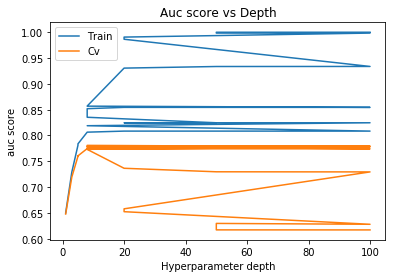

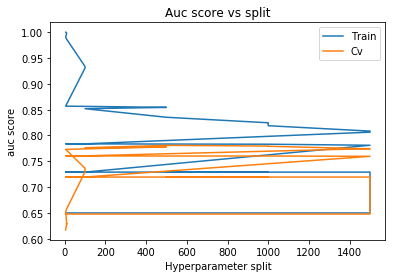

In [0]:
GridCvresult(GSC3)

#### 3D plot of Depth and split
![alt text](W2V.png "W2V")

So, balancing overfit and underfit
* Best max_depth 8 min_samples_split 500
* Best auc score is  78.08%

### Training model using best hyperparameters got from GridsearchCrossvalidation and further checking its performance

AUC score on test set: 72.881%
Accuracy on test set: 71.900%
Precision on test set: 94.608
Recall on test set: 71.531
F1-Score on test set: 81.467


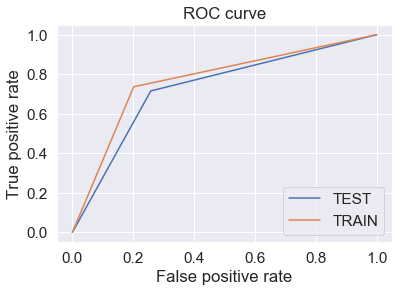

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



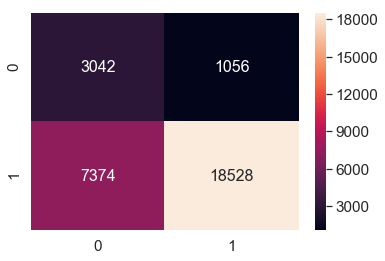

In [0]:
DecisionTree(depth,split,XtrainW2VV,XtestW2VV)

# TFIDF-weighted avg W2V vectorization-------------------------------------

In [0]:
tfmodel=TfidfVectorizer(max_features=2000)
tf_idf_matrix = tfmodel.fit_transform(Xtrain.values)
tfidf_feat=tfmodel.get_feature_names()
dictionary = {k:v for (k,v) in zip(tfmodel.get_feature_names(), list(tfmodel.idf_))}

In [0]:
def tfidfw2vVect(X):
    '''
    This function converts list of sentance into list of list of words and then 
    finally applies average-tfidf-w2w to get final sentance vector
    w2v model and w2v words already made during w2v vectorization part 
    '''
    lists=[]
    for sent in X.values:
        filtered_sentence=[]
        sent=cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if(cleaned_words.isalpha()):
                    filtered_sentence.append(cleaned_words.lower())
                else:
                    continue
        lists.append(filtered_sentence)
        
    tfidfw2v_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in lists: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            try:
                if word in w2v_words:
                    vec = w2v_model.wv[word]
                    #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                    #to reduce the computation we are 
                    #dictionary[word] = idf value of word in whole courpus
                    #sent.count(word) = tf valeus of word in this review
                    tf_idf = (dictionary[word])*((sent.count(word))/len(sent))
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
            except:
                pass
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidfw2v_sent_vectors.append(sent_vec)
        row += 1
    # converting nan and infinte values in vect to digit
    tfidfw2v_sent_vectors= np.nan_to_num(tfidfw2v_sent_vectors)
    return tfidfw2v_sent_vectors

In [0]:
# feeding text data and recieving vectorized data
XtrainTFIDFW2VV= tfidfw2vVect(Xtrain)
XtestTFIDFW2VV= tfidfw2vVect(Xtest)

In [0]:
#Standardizing vectors
std = StandardScaler(with_mean=False).fit(XtrainTFIDFW2VV)
XtrainTFIDFW2VV = std.transform(XtrainTFIDFW2VV)
XtestTFIDFW2VV = std.transform(XtestTFIDFW2VV)

### Using GridSearch for crossvalidation, we use here a function GridCvDt() which will return best parameters required

In [0]:
depth,split,GSC4= GridCvDt(XtrainTFIDFW2VV)


 DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Best Hyperparameter is  {'max_depth': 8, 'min_samples_split': 500}
Best auc score is  0.7520859743132027


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning:

You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True



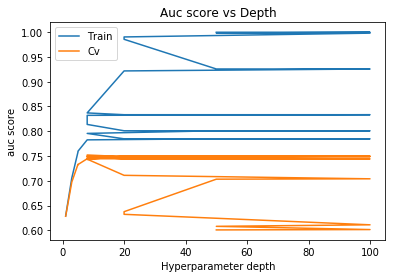

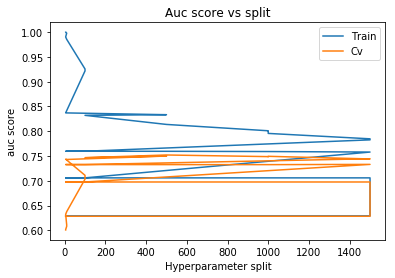

In [0]:
GridCvresult(GSC4)

#### 3D plot of Depth and split
![alt text](TFIDF-W2V.png "TFIDF-W2V")

So, balancing overfit and underfit
* Best max_depth 8 min_samples_split 500
* Best auc score is  72.50%

### Training model using best hyperparameters got from GridsearchCrossvalidation and further checking its performance

AUC score on test set: 69.096%
Accuracy on test set: 68.680%
Precision on test set: 93.455
Recall on test set: 68.524
F1-Score on test set: 79.071


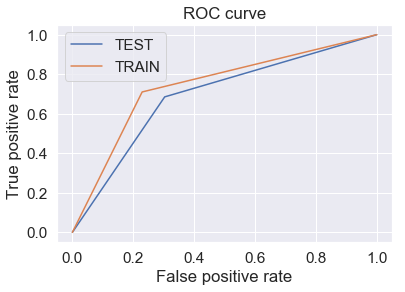

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



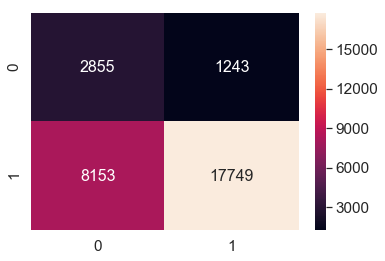

In [0]:
DecisionTree(depth,split,XtrainTFIDFW2VV,XtestTFIDFW2VV)

***
# <center>Summary</center>
## <center>Decision Tree</center>
Vectorizer|Optimal max_Depth|Optimal min_split|AUC Score|Accuracy|Precision|Recall|F1 Score
---|---|---|---|---|---|---|---
BOW |50|1500|74.399|74.113|94.887|74.006|83.155
TFIDF |50|1500|73.369|75.900|94.163|76.851|84.631
W2V |8|500|72.881|71.900|94.608|71.531|81.467
TFIDF-W2v |8|500|69.096|68.680|93.455|68.524|79.071

# Observations
* Best results were found using BOW with auc score of 74.4%
* DecisionTree Model is super interpretable as we can see feature importance directly and also visualize the tree
  it learned from train data (see tree in BOW and TFIDF vectorization) 
* As number of Features decresed from train data, DecisionTree model run very fast (we took around 30000 
  features in BOW whearas in TFIDF-avg-W2V we took only 50 features), So DecisionTree is very slow as compared to
  logisticRegressoin
* But logisticRegression was less interpretable than DecisionTrees

In [0]:
print('end\n\n\n\n\n')